# CNN Image Recognition Architecture Implementation


In [1]:
#GETTING THE CIFAR DATASET READY FOR EXPERIMENTATION
import tensorflow_datasets as tfds
import tensorflow as     tf
import math
import numpy             as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from utils.cifar_functions import *

#PREPARE THE CIFAR DATASET
# download data and split into training and testing datasets
dataset_train, info = tfds.load("cifar10", split=tfds.Split.TRAIN, with_info=True)
dataset_test,  info = tfds.load("cifar10", split=tfds.Split.TEST,  with_info=True)

dataset_train = dataset_train.map(pre_processing_train, num_parallel_calls=4)
dataset_train = dataset_train.shuffle(buffer_size=TRAINING_SHUFFLE_BUFFER)
dataset_train = dataset_train.batch(TRAINING_BATCH_SIZE)
dataset_train = dataset_train.prefetch(buffer_size=3)

# transform testing dataset
dataset_test = dataset_test.map(pre_processing_test, num_parallel_calls=4)
dataset_test = dataset_test.batch(TRAINING_BATCH_SIZE)
dataset_test = dataset_test.prefetch(buffer_size=3)

## CNN Architecture Utilities

In [2]:
from utils.cifar_functions import *

## ResNet Architecture

### Sources 
- [1](https://arxiv.org/pdf/1611.05431.pdf)
- [2](https://arxiv.org/pdf/1512.03385.pdf)
- [3](https://arxiv.org/pdf/1603.05027.pdf)

### Notes
[ResNet V1 Paper](https://arxiv.org/pdf/1512.03385.pdf)

__Intuition behind Residual Connenction__

*The degradation (of training accuracy) indicates that not
all systems are similarly easy to optimize... There exists a solution by construction
to the deeper model: the added layers are identity mapping,
and the other layers are copied from the learned shallower
model. The existence of this constructed solution indicates
that a deeper model should produce no higher training error
than its shallower counterpart.*

*or unable to do so in feasible time).
In this paper, we address the degradation problem by
introducing a deep residual learning framework.... we let the stacked nonlinear
layers fit another mapping of F(x) := H(x)−x. The original mapping is recast into F(x)+x. We hypothesize that it
is easier to optimize the residual mapping than to optimize
the original, unreferenced mapping. To the extreme, if an
identity mapping were optimal, it would be easier to push
the residual to zero than to fit an identity mapping by a stack
of nonlinear layers.*

*. With the residual learning reformulation, if identity mappings are optimal, the solvers
may simply drive the weights of the multiple nonlinear layers toward zero to approach identity mappings.*
VGG style architecture with bottleneck "residual blocks" that allow propagation of gradients cleanly anywhere in the network. Allows the training of arbitratily deep networks by allowing the network to easily map a layer to an *identity function*, zeroeing out the parameters of network layers that do not improve performance.

More Notes: 
- For downsampling blocks where the shape of the input is changed, the "identity path" must go through a 1x1 Conv layer w/ stride 2 and no activation.
- Activation and batch norm are best applied __before__ the convolution operation (within the residual path).

__What to do during down sampling__

*The dimensions of x and F must be equal in Eqn.(1).
If this is not the case (e.g., when changing the input/output
channels), we can perform a __linear projection Ws__ by the
shortcut connections to match the dimensions:
y = F(x, {Wi}) + Wsx.*

*The identity shortcuts (Eqn.(1)) can be directly used when the input and utput are of the same dimensions (solid line shortcuts in ig. 3). When the dimensions increase (dotted line shortcuts in Fig. 3), we consider two options: (A) The shortcut still performs identity mapping, with extra zero entries padded for increasing dimensions. This option introduces no extra parameter; (B) __The projection shortcut in Eqn.(2) is used to match dimensions (done by 1×1 convolutions)__. For both options, when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2.*

In [3]:
#RESNET V1
def resnet_tail(inputs, dims):
    return Conv2D(dims, (3,3), **conv_params)(inputs)

def resnet_block(inputs, expand_dims, squeeze_ratio=.25, downsample=False):
    """
    INPUTS
    inputs: tensor
    exand_dims: int
    squeeze_ratio: float - multiplier to squeeze channel dimenions in bottleneck
    
    Bottleneck implementation of a ResNet block
    conv 1x1 -> squeeze the number of channel dimensions to squeeze_channels
    conv 3x3 -> map spatial data still low dim
    conv 1x1 -> expand dimensions on channel axis to expand_dims
    """
    squeeze_dims= int(expand_dims // (1/squeeze_ratio))
    if downsample:
        strides =(2,2)
    else:
        strides=(1,1)
        
    #RESIDUAL PATH
    resid = BatchNormalization(**bn_params)(inputs)  #Note that BN and ReLU are preactivations
    resid = ReLU()(resid)
    resid = conv_block(resid, squeeze_dims, kernel_size=(1,1), strides=strides) #potential improvement, no activation after squeeze
    resid = conv_block(resid, squeeze_dims, kernel_size=(3,3))
    resid = Conv2D(expand_dims, (1,1), **conv_params)(resid)
    
    #IDENTITY PATH
    if downsample:
        inputs = Conv2D(expand_dims, (1,1), strides=strides, **conv_params)(inputs)
    
    #COMBINE
    return Add()([inputs, resid])

def resnet_head(inputs, dims=None):
    # NOT SURE IF THERE NEEDS TO BE A BN RELU HERE
    # IT WILL OBSTRUCT BACKPROP THROUGH IDENTITY
    x = BatchNormalization(**bn_params)
    x = GlobalAveragePooling2D()(inputs)
    return Dense(DATA_NUM_CLASSES, activation='softmax')(x)

In [4]:
resnet = VGG_Like_CNN(resnet_tail,
            resnet_block,
            resnet_head,
            input_shape = (DATA_CROP_ROWS, DATA_CROP_COLS, DATA_CHANNELS),
            num_levels= 3,
             num_downsamples=2,
            block_repeats=BLOCK_REPEATS)

resnet.compile(optimizer = tf.keras.optimizers.Adam(TRAINING_LR_MAX),
              loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [5]:
hist = train(resnet,dataset_train, dataset_test,  'resnet_w_bottleneck', logs=True)

######################################################
resnet_w_bottleneck
######################################################


Training model resnet_w_bottleneck...
Epoch 1/30
782/782 [==============================] - 34s 44ms/step - loss: 2.2166 - accuracy: 0.1782 - val_loss: 2.0735 - val_accuracy: 0.2308
Epoch 2/30
782/782 [==============================] - 26s 34ms/step - loss: 1.7082 - accuracy: 0.3645 - val_loss: 1.4906 - val_accuracy: 0.4414
Epoch 3/30
782/782 [==============================] - 26s 34ms/step - loss: 1.4410 - accuracy: 0.4686 - val_loss: 1.3008 - val_accuracy: 0.5280
Epoch 4/30
782/782 [==============================] - 26s 34ms/step - loss: 1.2760 - accuracy: 0.5399 - val_loss: 1.2030 - val_accuracy: 0.5573
Epoch 5/30
782/782 [==============================] - 27s 34ms/step - loss: 1.1363 - accuracy: 0.5931 - val_loss: 1.0579 - val_accuracy: 0.6262
Epoch 6/30
782/782 [==============================] - 26s 34ms/step - loss: 1.0271 - accuracy: 0.6367 - val_loss: 1.0920 - val_accuracy: 0.6235
Epoch 7/30
782/782 [==============================] - 26s 34ms/step - loss: 0.9209 - accuracy: 0.6

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: F://Models/Model_Design/resnet_w_bottleneck/assets


INFO:tensorflow:Assets written to: F://Models/Model_Design/resnet_w_bottleneck/assets


782/782 [==============================] - 46s 59ms/step - loss: 0.7246 - accuracy: 0.7481 - val_loss: 0.7503 - val_accuracy: 0.7416
Epoch 11/30
782/782 [==============================] - 27s 34ms/step - loss: 0.6842 - accuracy: 0.7626 - val_loss: 0.6891 - val_accuracy: 0.7566
Epoch 12/30
782/782 [==============================] - 27s 34ms/step - loss: 0.6543 - accuracy: 0.7732 - val_loss: 0.6746 - val_accuracy: 0.7691
Epoch 13/30
782/782 [==============================] - 27s 34ms/step - loss: 0.6201 - accuracy: 0.7849 - val_loss: 0.6363 - val_accuracy: 0.7806
Epoch 14/30
782/782 [==============================] - 27s 35ms/step - loss: 0.5895 - accuracy: 0.7939 - val_loss: 0.5833 - val_accuracy: 0.7994
Epoch 15/30
782/782 [==============================] - 28s 36ms/step - loss: 0.5694 - accuracy: 0.8030 - val_loss: 0.5765 - val_accuracy: 0.8039
Epoch 16/30
782/782 [==============================] - 27s 34ms/step - loss: 0.5426 - accuracy: 0.8102 - val_loss: 0.5497 - val_accuracy: 0.80

INFO:tensorflow:Assets written to: F://Models/Model_Design/resnet_w_bottleneck/assets


782/782 [==============================] - 46s 59ms/step - loss: 0.4689 - accuracy: 0.8377 - val_loss: 0.5233 - val_accuracy: 0.8235
Epoch 21/30
782/782 [==============================] - 26s 33ms/step - loss: 0.4543 - accuracy: 0.8407 - val_loss: 0.4981 - val_accuracy: 0.8291
Epoch 22/30
782/782 [==============================] - 26s 34ms/step - loss: 0.4357 - accuracy: 0.8479 - val_loss: 0.4758 - val_accuracy: 0.8341
Epoch 23/30
782/782 [==============================] - 26s 33ms/step - loss: 0.4160 - accuracy: 0.8561 - val_loss: 0.4649 - val_accuracy: 0.8391
Epoch 24/30
782/782 [==============================] - 27s 35ms/step - loss: 0.4060 - accuracy: 0.8577 - val_loss: 0.4712 - val_accuracy: 0.8397
Epoch 25/30
782/782 [==============================] - 27s 35ms/step - loss: 0.3880 - accuracy: 0.8649 - val_loss: 0.4473 - val_accuracy: 0.8462
Epoch 26/30
782/782 [==============================] - 27s 35ms/step - loss: 0.3752 - accuracy: 0.8687 - val_loss: 0.4420 - val_accuracy: 0.85

INFO:tensorflow:Assets written to: F://Models/Model_Design/resnet_w_bottleneck/assets


782/782 [==============================] - 46s 59ms/step - loss: 0.3249 - accuracy: 0.8858 - val_loss: 0.4230 - val_accuracy: 0.8555
Training complete.


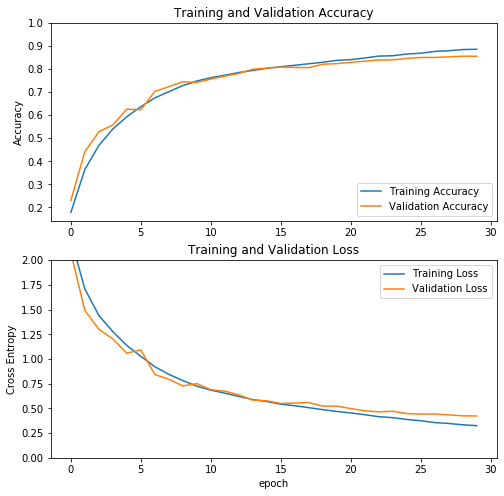

    157/Unknown - 2s 13ms/step - loss: 0.4230 - accuracy: 0.8555 2s 13ms/stTest loss:      0.42297725218116855
Test accuracy:  0.8555


In [6]:
benchmark(resnet, dataset_test, hist, 'resnet_w_bottleneck')

### Potential Improvements
- MobileNet V2 paper suggested that the ReLU activation throws away a lot of information in the bottleneck layer output. Their suggestion, no activation after the bottleneck layer.

## MobileNet V2 Architecture

- [1](https://arxiv.org/pdf/1801.04381.pdf)

- [2](https://towardsdatascience.com/mobilenetv2-inverted-residuals-and-linear-bottlenecks-8a4362f4ffd5)

__Main Contributions__
- Depthwise Seperable Convolutions - reduce the computational complexity of a standard 2D Conv by replacing this layer with two layers. The first, a __3x3 depthwise convolution__ applying K kernels with each channel (where K is the number of input channels). Second, a __1x1 pointwise convolution__ to produce linear combinations of channel pixels.

- Linear Bottlenecks - TLDR when you are compressing your representation with a convolutional operation, do not use a nonlinearity after the compression. (especially ReLU which throws out negative activations) Instead, make bottleneck layers linear operations.

- Inverted Residuals

In [7]:
def mobilenet_v2_tail(inputs, dims):
    return Conv2D(dims, (3,3), **conv_params)(inputs)

def inverted_residual(inputs, squeeze_dims, expand_ratio=4, downsample=False):
    """
    inputs: Tensor- input to the first layer
    squeeze_dims: int - depth of the channel dimension after squeeze
    expand_ratio: float - multiplier to expand channel dimenions after bottleneck
    downsample: bool - whether to downsample the image
    
    Inverted residual a la MobileNet V2 note the channel dimension will
     be expanded by pointwise conv, processed with depthwise conv, then 
     compressed by a linear bottleneck
    """
    
    expand_dims = int(squeeze_dims * expand_ratio)
    if downsample:
        strides =(2,2)
    else:
        strides=(1,1)
                
    #RESIDUAL PATH (EXPAND - > COMPRESS)
    x = Conv2D(expand_dims, (1, 1), strides=strides, **conv_params)(inputs) #expansion (linear comb across channels)
    x = BatchNormalization(**bn_params)(x)
    x = ReLU(max_value=6)(x)  # the paper uses ReLU6, a thresholded ReLU (3-bit output)

    x = DepthwiseConv2D((3,3), strides=(1,1), **conv_params)(x) #depthwise conv (for spatial data)
    x = BatchNormalization(**bn_params)(x)
    x = ReLU(max_value=6)(x)
    
    x = Conv2D(squeeze_dims, (1, 1), strides=(1, 1), **conv_params)(x) #bottleneck layer
    x = BatchNormalization(**bn_params)(x) #No activation here (Linear BottleNeck)
    
    #IDENTITY PATH
    if downsample: # maintain dimensions during downsampling
        inputs = Conv2D(squeeze_dims, (1, 1), strides=strides, padding='same')(inputs)
    
    #COMBINE
    return Add()([x, inputs])

def mobilenet_v2_head(inputs, dims=None):
    x = Conv2D(dims, (1, 1), strides=(1,1), padding='same')(inputs)
    x = GlobalAveragePooling2D()(x)
    return Dense(DATA_NUM_CLASSES, activation='softmax')(x)

In [8]:
mobilenet_v2 = VGG_Like_CNN(mobilenet_v2_tail,
            inverted_residual,
            mobilenet_v2_head,
            input_shape = (DATA_CROP_ROWS, DATA_CROP_COLS, DATA_CHANNELS),
            num_levels= 3,
            num_downsamples=2,
            block_repeats=BLOCK_REPEATS)

mobilenet_v2.compile(optimizer = tf.keras.optimizers.Adam(TRAINING_LR_MAX),
              loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [9]:
hist = train(mobilenet_v2,dataset_train, dataset_test, 'mobilenet_v2', logs=True)

######################################################
mobilenet_v2
######################################################


Training model mobilenet_v2...
Epoch 1/30
782/782 [==============================] - 72s 92ms/step - loss: 1.9231 - accuracy: 0.3059 - val_loss: 1.6549 - val_accuracy: 0.3964
Epoch 2/30
782/782 [==============================] - 66s 84ms/step - loss: 1.3542 - accuracy: 0.5134 - val_loss: 1.1472 - val_accuracy: 0.5860
Epoch 3/30
782/782 [==============================] - 66s 84ms/step - loss: 1.0593 - accuracy: 0.6243 - val_loss: 0.9590 - val_accuracy: 0.6571
Epoch 4/30
782/782 [==============================] - 66s 84ms/step - loss: 0.8609 - accuracy: 0.7008 - val_loss: 0.8085 - val_accuracy: 0.7226
Epoch 5/30
782/782 [==============================] - 66s 85ms/step - loss: 0.7350 - accuracy: 0.7457 - val_loss: 0.7436 - val_accuracy: 0.7453
Epoch 6/30
782/782 [==============================] - 66s 84ms/step - loss: 0.6562 - accuracy: 0.7736 - val_loss: 0.6915 - val_accuracy: 0.7636
Epoch 7/30
782/782 [==============================] - 64s 82ms/step - loss: 0.5734 - accuracy: 0.8018 - v

INFO:tensorflow:Assets written to: F://Models/Model_Design/mobilenet_v2/assets


782/782 [==============================] - 85s 108ms/step - loss: 0.4342 - accuracy: 0.8502 - val_loss: 0.4951 - val_accuracy: 0.8293
Epoch 11/30
782/782 [==============================] - 65s 83ms/step - loss: 0.4017 - accuracy: 0.8624 - val_loss: 0.4323 - val_accuracy: 0.8547
Epoch 12/30
782/782 [==============================] - 64s 82ms/step - loss: 0.3762 - accuracy: 0.8681 - val_loss: 0.4413 - val_accuracy: 0.8522
Epoch 13/30
782/782 [==============================] - 64s 82ms/step - loss: 0.3482 - accuracy: 0.8805 - val_loss: 0.4157 - val_accuracy: 0.8622
Epoch 14/30
782/782 [==============================] - 65s 83ms/step - loss: 0.3216 - accuracy: 0.8886 - val_loss: 0.3820 - val_accuracy: 0.8749
Epoch 15/30
782/782 [==============================] - 65s 83ms/step - loss: 0.2981 - accuracy: 0.8946 - val_loss: 0.3927 - val_accuracy: 0.8708
Epoch 16/30
782/782 [==============================] - 65s 83ms/step - loss: 0.2769 - accuracy: 0.9031 - val_loss: 0.3576 - val_accuracy: 0.8

INFO:tensorflow:Assets written to: F://Models/Model_Design/mobilenet_v2/assets


782/782 [==============================] - 85s 109ms/step - loss: 0.1957 - accuracy: 0.9321 - val_loss: 0.3106 - val_accuracy: 0.8983
Epoch 21/30
782/782 [==============================] - 65s 84ms/step - loss: 0.1740 - accuracy: 0.9383 - val_loss: 0.3271 - val_accuracy: 0.8943
Epoch 22/30
782/782 [==============================] - 65s 83ms/step - loss: 0.1576 - accuracy: 0.9448 - val_loss: 0.3117 - val_accuracy: 0.9050
Epoch 23/30
782/782 [==============================] - 65s 83ms/step - loss: 0.1397 - accuracy: 0.9513 - val_loss: 0.3277 - val_accuracy: 0.9030
Epoch 24/30
782/782 [==============================] - 65s 83ms/step - loss: 0.1228 - accuracy: 0.9569 - val_loss: 0.3119 - val_accuracy: 0.9064
Epoch 25/30
782/782 [==============================] - 65s 83ms/step - loss: 0.1029 - accuracy: 0.9640 - val_loss: 0.3104 - val_accuracy: 0.9099
Epoch 26/30
782/782 [==============================] - 67s 85ms/step - loss: 0.0834 - accuracy: 0.9707 - val_loss: 0.3097 - val_accuracy: 0.9

INFO:tensorflow:Assets written to: F://Models/Model_Design/mobilenet_v2/assets


782/782 [==============================] - 86s 111ms/step - loss: 0.0418 - accuracy: 0.9858 - val_loss: 0.2948 - val_accuracy: 0.9215
Training complete.


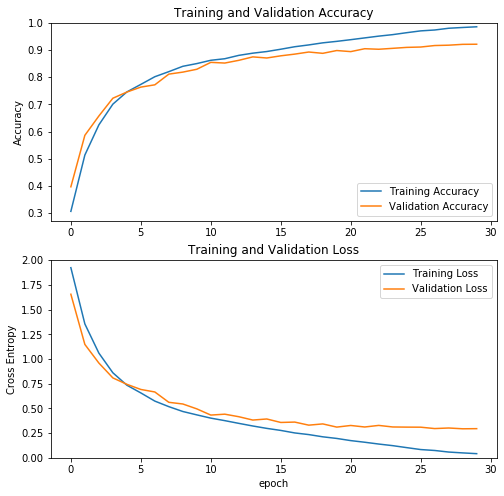

    157/Unknown - 4s 28ms/step - loss: 0.2948 - accuracy: 0.9215 4s 28ms/step - loss: 0.2966 - accuracy: Test loss:      0.2948434254166427
Test accuracy:  0.9215


In [10]:
benchmark(mobilenet_v2, dataset_test, hist, 'mobilenet_v2')

In [11]:
#Xception Implementation  https://arxiv.org/abs/1610.02357

In [12]:
#Inception V4 Implementation  https://arxiv.org/abs/1602.07261

In [13]:
#NASNet Implementation  https://arxiv.org/abs/1707.07012

In [14]:
#MnasNet Implementation  https://arxiv.org/abs/1807.11626

In [15]:
#AmoebaNet Implementation  https://arxiv.org/abs/1802.01548

In [16]:
#Squeeze and Excite Implementation   https://arxiv.org/abs/1709.01507

In [17]:
#ShuffleNet V2 Implementation  https://arxiv.org/abs/1707.01083

In [18]:
#EfficientNet Implementation https://arxiv.org/abs/1905.11946v3

# Awesome Papers

## ImageNet

https://paperswithcode.com/paper/self-training-with-noisy-student-improves

https://paperswithcode.com/paper/large-scale-learning-of-general-visual

https://paperswithcode.com/paper/fixing-the-train-test-resolution-discrepancy

https://paperswithcode.com/paper/exploring-the-limits-of-weakly-supervised

https://paperswithcode.com/paper/gpipe-efficient-training-of-giant-neural

https://paperswithcode.com/paper/compounding-the-performance-improvements-of

https://paperswithcode.com/paper/billion-scale-semi-supervised-learning-for

https://paperswithcode.com/paper/randaugment-practical-data-augmentation-with

https://paperswithcode.com/paper/adversarial-examples-improve-image

https://paperswithcode.com/paper/multigrain-a-unified-image-embedding-for

https://paperswithcode.com/paper/drop-an-octave-reducing-spatial-redundancy-in

https://paperswithcode.com/paper/harmonic-convolutional-networks-based-on

https://paperswithcode.com/paper/selective-kernel-networks

https://paperswithcode.com/paper/ghostnet-more-features-from-cheap-operations

https://paperswithcode.com/paper/shufflenet-v2-practical-guidelines-for

https://paperswithcode.com/paper/searching-for-mobilenetv3

https://paperswithcode.com/paper/whats-hidden-in-a-randomly-weighted-neural

https://paperswithcode.com/paper/xception-deep-learning-with-depthwise

https://paperswithcode.com/paper/polynet-a-pursuit-of-structural-diversity-in


## MNIST

https://paperswithcode.com/paper/a-branching-and-merging-convolutional-network

https://paperswithcode.com/paper/stochastic-optimization-of-plain



## CIFAR -10


https://paperswithcode.com/paper/large-scale-learning-of-general-visual

https://paperswithcode.com/paper/gpipe-efficient-training-of-giant-neural

https://paperswithcode.com/paper/efficientnet-rethinking-model-scaling-for

https://paperswithcode.com/paper/understanding-and-enhancing-mixed-sample-data

https://paperswithcode.com/paper/large-scale-learning-of-general-visual

https://paperswithcode.com/paper/fast-autoaugment

https://paperswithcode.com/paper/enaet-self-trained-ensemble-autoencoding

https://paperswithcode.com/paper/proxylessnas-direct-neural-architecture

https://paperswithcode.com/paper/squeeze-and-excitation-networks

https://paperswithcode.com/paper/proxylessnas-direct-neural-architecture

https://paperswithcode.com/paper/squeeze-and-excitation-networks

https://paperswithcode.com/paper/fixup-initialization-residual-learning

https://paperswithcode.com/paper/batchboost-regularization-for-stabilizing

https://paperswithcode.com/paper/learning-implicitly-recurrent-cnns-through

https://paperswithcode.com/paper/manifold-mixup-better-representations-by

https://paperswithcode.com/paper/mixup-beyond-empirical-risk-minimization

https://paperswithcode.com/paper/averaging-weights-leads-to-wider-optima-and

https://paperswithcode.com/paper/deep-pyramidal-residual-networks


## CIFAR 100

https://paperswithcode.com/paper/cutmix-regularization-strategy-to-train

https://paperswithcode.com/paper/fast-autoaugment

https://paperswithcode.com/paper/understanding-and-enhancing-mixed-sample-data

https://paperswithcode.com/paper/res2net-a-new-multi-scale-backbone

https://paperswithcode.com/paper/enaet-self-trained-ensemble-autoencoding

https://paperswithcode.com/paper/single-bit-per-weight-deep-convolutional

https://paperswithcode.com/paper/towards-principled-design-of-deep

https://paperswithcode.com/paper/training-neural-networks-with-local-error